# Neural Networks and Deep Learning Spring 1400 <img src = 'https://ece.ut.ac.ir/cict-theme/images/footer-logo.png' alt="Tehran-University-Logo" width="150" height="150" align="right">
## Extra Homework 1 - Question 2


### By Omid Vaheb
### 810196582

## Importing Required Libraries

In [6]:
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import sample, choice
from PIL import Image
from tensorflow.keras import Sequential 
from tensorflow.keras.utils import Sequence, to_categorical, plot_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Input, MaxPooling2D, concatenate, BatchNormalization, Activation, Dropout
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os
import warnings
import zipfile

In [7]:
warnings.filterwarnings("ignore")

In [8]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

## Mounting Kaggle Dataset Handler

In [9]:
! pip install -q kaggle

In [10]:
from google.colab import files

In [11]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"omidvaheb","key":"42a5abdb00ca31de6e2cfbfec88cfd12"}'}

In [12]:
 ! mkdir ~/.kaggle
 ! cp kaggle.json ~/.kaggle/

In [13]:
 ! chmod 600 ~/.kaggle/kaggle.json
 ! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              229KB  2021-06-01 11:18:46           6994  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           4208  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           1397  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27           2159  
mathurinache/twitter-edge-nodes                             Twitter Edge Nod

## Loading Dataset

In [14]:
!kaggle datasets download -d jcoral02/camvid

100% 1.12G/1.12G [00:10<00:00, 111MB/s] 
100% 1.12G/1.12G [00:10<00:00, 119MB/s]


In [15]:
zip_ref = zipfile.ZipFile('camvid.zip', 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

## Pairing Original Photos with Masked Ones

In [16]:
print("Number of Train Data :", len(os.listdir('/tmp/CamVid/train')))
print("Number of Validation Data :", len(os.listdir('/tmp/CamVid/val')))
print("Number of Test Data :", len(os.listdir('/tmp/CamVid/test')))

Number of Train Data : 367
Number of Validation Data : 101
Number of Test Data : 233


In [17]:
def make_pair(images, image_dir, mask_dir):
    pairs = []
    for image in images:
        pairs.append((image_dir + image, mask_dir + image.split('.')[0] + '_L.png'))
    return pairs

In [18]:
train_pairs = make_pair(os.listdir('/tmp/CamVid/train'), "/tmp/CamVid/train/", "/tmp/CamVid/train_labels/")
val_pairs = make_pair(os.listdir('/tmp/CamVid/val'), "/tmp/CamVid/val/", "/tmp/CamVid/val_labels/")
test_pairs = make_pair(os.listdir('/tmp/CamVid/test'), "/tmp/CamVid/test/", "/tmp/CamVid/test_labels/")

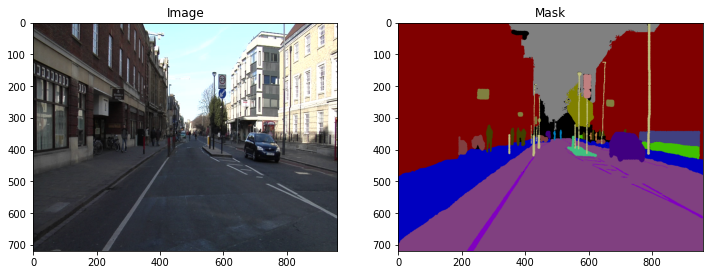

In [19]:
temp = choice(train_pairs)
img = img_to_array(load_img(temp[0]))
mask = img_to_array(load_img(temp[1]))
plt.figure(figsize=(12,12))
plt.subplot(121)
plt.title("Image")
plt.imshow(img/255)
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask/255)
plt.show()

## Specifying Label of Masks

In [20]:
class_map_df = pd.read_csv("/tmp/CamVid/class_dict.csv")
class_map_df.head()

,name,r,g,b,class_11
0,Animal,64,128,64,0
1,Archway,192,0,128,0
2,Bicyclist,0,128,192,1
3,Bridge,0,128,64,0
4,Building,128,0,0,1


In [21]:
class_map = []
for index,item in class_map_df.iterrows():
    class_map.append(np.array([item['r'], item['g'], item['b']]))
    
print(len(class_map))
print(class_map[0])

32
[ 64 128  64]


In [22]:
def assert_map_range(mask,class_map):
    mask = mask.astype("uint8")
    for j in range(img_size):
        for k in range(img_size):
            assert mask[j][k] in class_map , tuple(mask[j][k])

In [23]:
def form_2D_label(mask, class_map):
    mask = mask.astype("uint8")
    label = np.zeros(mask.shape[:2],dtype= np.uint8)
    for i, rgb in enumerate(class_map):
        label[(mask == rgb).all(axis=2)] = i
    return label

In [24]:
lab = form_2D_label(mask, class_map)
np.unique(lab, return_counts=True)

(array([ 2,  4,  5,  7,  8,  9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 26, 30,
        31], dtype=uint8),
 array([   336, 271891,   8816,    234,   8156,   7301,   6875,   2240,
          3432,   1844,   3656, 230615,  58058,   1727,  62917,   6462,
         11199,   5441]))

## DataGenerator Class

In [26]:
class DataGenerator(Sequence):
    def __init__(self, pair,class_map,  batch_size=16, dim=(224,224,3), shuffle=True):
        self.dim = dim
        self.pair = pair
        self.class_map = class_map
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.pair) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [k for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)

        return X, y
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.pair))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        batch_imgs = list()
        batch_labels = list()
        for i in list_IDs_temp:
            img = load_img(self.pair[i][0] ,target_size=self.dim)
            img = img_to_array(img)/255.
            batch_imgs.append(img)
            label = load_img(self.pair[i][1],target_size=self.dim)
            label = img_to_array(label)
            label = form_2D_label(label,self.class_map)
            label = np.asarray(to_categorical(label , num_classes = 32))
            batch_labels.append(label)
        return np.array(batch_imgs) ,np.array(batch_labels)

(4, 512, 512, 3) (4, 512, 512, 32)
Images


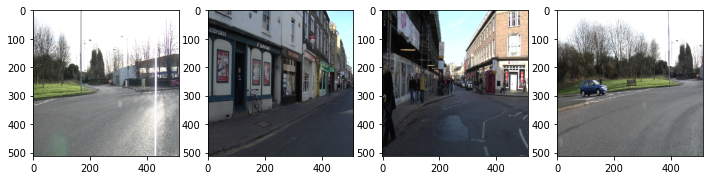

In [28]:
img_size = 512
train_generator1 = DataGenerator(train_pairs,class_map,batch_size=4, dim=(img_size,img_size,3) ,shuffle=True)
X,y = train_generator1.__getitem__(0)
print(X.shape, y.shape)

plt.figure(figsize=(12, 6))
print("Images")
for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.imshow(X[i])
plt.show()

#print("Masks")
#plt.figure(figsize=(12, 6))
#for i in range(4):
#    plt.subplot(2, 4, i+1)
#    plt.imshow(y[i])
#plt.show()

In [29]:
train_generator = DataGenerator(train_pairs, class_map,batch_size=4, dim=(img_size,img_size,3) ,shuffle=True)
val_generator = DataGenerator(val_pairs, class_map, batch_size=4, dim=(img_size,img_size,3) ,shuffle=True)
test_generator = DataGenerator(test_pairs, class_map, batch_size=4, dim=(img_size,img_size,3) ,shuffle=True)

## Creating Model

In [30]:
def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal"):
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def deconv_block(tensor, residual, nfilters, size=3, padding='same', strides=(2, 2)):
    y = Conv2DTranspose(nfilters, kernel_size=(size, size), strides=strides, padding=padding)(tensor)
    y = concatenate([y, residual], axis=3)
    y = conv_block(y, nfilters)
    return y
def Unet(h, w, filters, num_classes = 32):
    input_layer = Input(shape=(h, w, 3), name='image_input')
    conv1 = conv_block(input_layer, nfilters=filters)
    conv1_out = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(conv1_out, nfilters=filters*2)
    conv2_out = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(conv2_out, nfilters=filters*4)
    conv3_out = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(conv3_out, nfilters=filters*8)
    conv4_out = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4_out = Dropout(0.5)(conv4_out)
    conv5 = conv_block(conv4_out, nfilters=filters*16)
    conv5 = Dropout(0.5)(conv5)
    deconv6 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
    deconv6 = Dropout(0.5)(deconv6)
    deconv7 = deconv_block(deconv6, residual=conv3, nfilters=filters*4)
    deconv7 = Dropout(0.5)(deconv7) 
    deconv8 = deconv_block(deconv7, residual=conv2, nfilters=filters*2)
    deconv9 = deconv_block(deconv8, residual=conv1, nfilters=filters)
    output_layer = Conv2D(filters=num_classes, kernel_size=(1, 1), activation='softmax')(deconv9)
    model = Model(inputs=input_layer, outputs=output_layer, name='Unet')
    return model

## Summary of Model

In [31]:
model = Unet(img_size , img_size , 64)
model.summary()

Model: "Unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 1792        image_input[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 64) 0           batch_normalization[0][0]        
_______________________________________________________________________________________________

In [32]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
mc = ModelCheckpoint(mode='max', filepath='top-weights.h5', monitor='val_acc',save_best_only='True', verbose=1)
es = EarlyStopping(monitor='val_acc', patience=10, verbose=0)

In [34]:
train_steps = train_generator.__len__()
val_steps = val_generator.__len__()

print(train_steps, val_steps)

91 25


## Training Model

In [35]:
results = model.fit_generator(train_generator,steps_per_epoch=train_steps,
                              epochs=25,validation_data=val_generator,
                              validation_steps=val_steps,callbacks=[mc,es],
                              verbose = 1)

Epoch 1/25
91/91 [==============================] - 196s 2s/step - loss: 1.4591 - accuracy: 0.6464 - val_loss: 21.5913 - val_accuracy: 0.3990
Epoch 2/25
91/91 [==============================] - 149s 2s/step - loss: 0.9780 - accuracy: 0.7313 - val_loss: 2.0010 - val_accuracy: 0.4227
Epoch 3/25
91/91 [==============================] - 148s 2s/step - loss: 0.8924 - accuracy: 0.7523 - val_loss: 1.9989 - val_accuracy: 0.5766
Epoch 4/25
91/91 [==============================] - 148s 2s/step - loss: 0.8085 - accuracy: 0.7746 - val_loss: 0.9833 - val_accuracy: 0.7392
Epoch 5/25
91/91 [==============================] - 148s 2s/step - loss: 0.7732 - accuracy: 0.7801 - val_loss: 1.0080 - val_accuracy: 0.7192
Epoch 6/25
91/91 [==============================] - 148s 2s/step - loss: 0.7161 - accuracy: 0.7988 - val_loss: 0.7832 - val_accuracy: 0.7899
Epoch 7/25
91/91 [==============================] - 148s 2s/step - loss: 0.6668 - accuracy: 0.8101 - val_loss: 0.9934 - val_accuracy: 0.7075
Epoch 8/25
9

In [36]:
model.save('./camvid_unet_model.h5')

## Accuracy and Loss Plots

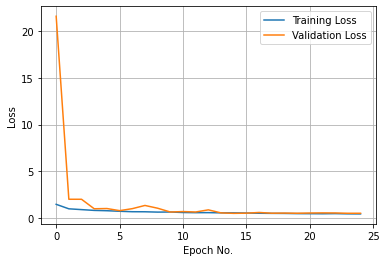

In [37]:
plt.plot(results.history['loss'], label = 'Training Loss')
plt.plot(results.history['val_loss'], label = 'Validation Loss')
plt.xlabel("Epoch No.")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

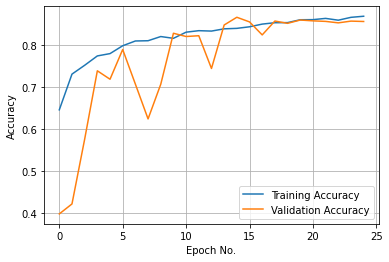

In [38]:
plt.plot(results.history['accuracy'], label = 'Training Accuracy')
plt.plot(results.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel("Epoch No.")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

## Evaluating Model Using Test Data

In [39]:
trained_model = keras.models.load_model("/content/camvid_unet_model.h5")

In [40]:
model.evaluate_generator(test_generator)

[0.8660489320755005, 0.7506104707717896]

In [41]:
x_test, y_test = test_generator.__getitem__(2)
print(x_test.shape, y_test.shape)

(4, 512, 512, 3) (4, 512, 512, 32)


In [42]:
y_pred = trained_model.predict(x_test, verbose = 1, batch_size = 4)
y_pred.shape

1/1 [==============================] - 12s 12s/step


(4, 512, 512, 32)

In [43]:
def map_this(y_pred,class_map):
    y_pred_rgb = np.zeros((y_pred.shape[0],y_pred.shape[1],y_pred.shape[2],3))
    for i in range(y_pred.shape[0]):
        image = np.zeros((y_pred.shape[1],y_pred.shape[2],3))
        for j in range(y_pred.shape[1]):
            for k in range(y_pred.shape[2]):
                image[j,k,:] = class_map[y_pred[i][j][k]]
        y_pred_rgb[i] = image
    return y_pred_rgb

In [44]:
def plot_result(img , title):
    plt.figure(figsize=(12, 6))
    plt.title(title)
    for i in range(4):
        plt.subplot(2, 4, i+1)
        plt.imshow(img[i])
    plt.show()

In [45]:
pred = np.argmax(y_pred, axis=3)
y_pred_rgb = map_this(pred,class_map)
test = np.argmax(y_test, axis=3)
y_test_rgb = map_this(test,class_map)

## Observing Results of Segmentation

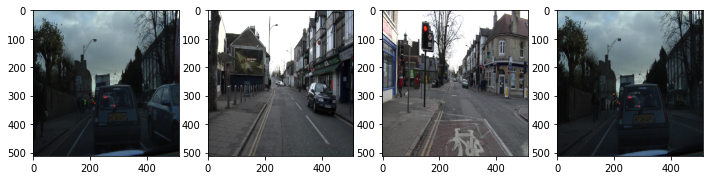

In [46]:
plot_result(x_test, "Test Images")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


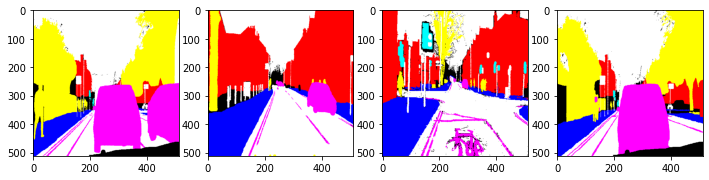

In [47]:
plot_result(y_test_rgb, "Original Masks")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


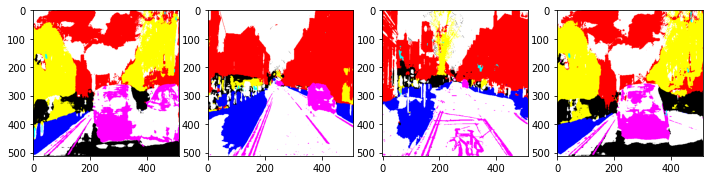

In [48]:
plot_result(y_pred_rgb,"Predicted mask")